<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Multiple-Sclerosis-EDA" data-toc-modified-id="Multiple-Sclerosis-EDA-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Multiple Sclerosis EDA</a></span><ul class="toc-item"><li><span><a href="#TASKS" data-toc-modified-id="TASKS-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>TASKS</a></span></li><li><span><a href="#Patient-Information" data-toc-modified-id="Patient-Information-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Patient Information</a></span></li><li><span><a href="#Lesion-description" data-toc-modified-id="Lesion-description-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Lesion description</a></span></li><li><span><a href="#Merged-dataframe-1" data-toc-modified-id="Merged-dataframe-1-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Merged dataframe 1</a></span></li><li><span><a href="#EDSS" data-toc-modified-id="EDSS-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>EDSS</a></span></li><li><span><a href="#Merge-with-EDSS" data-toc-modified-id="Merge-with-EDSS-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Merge with EDSS</a></span></li><li><span><a href="#EDSS-Score" data-toc-modified-id="EDSS-Score-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>EDSS Score</a></span></li><li><span><a href="#Hypothesis-testing-part" data-toc-modified-id="Hypothesis-testing-part-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Hypothesis testing part</a></span><ul class="toc-item"><li><span><a href="#Trying-correlation-map" data-toc-modified-id="Trying-correlation-map-1.8.1"><span class="toc-item-num">1.8.1&nbsp;&nbsp;</span>Trying correlation map</a></span></li><li><span><a href="#Related-features" data-toc-modified-id="Related-features-1.8.2"><span class="toc-item-num">1.8.2&nbsp;&nbsp;</span>Related features</a></span></li><li><span><a href="#Adding-more-features" data-toc-modified-id="Adding-more-features-1.8.3"><span class="toc-item-num">1.8.3&nbsp;&nbsp;</span>Adding more features</a></span></li><li><span><a href="#Feature-Importance" data-toc-modified-id="Feature-Importance-1.8.4"><span class="toc-item-num">1.8.4&nbsp;&nbsp;</span>Feature Importance</a></span></li><li><span><a href="#Trying-other-plots" data-toc-modified-id="Trying-other-plots-1.8.5"><span class="toc-item-num">1.8.5&nbsp;&nbsp;</span>Trying other plots</a></span></li></ul></li><li><span><a href="#Hypothesis" data-toc-modified-id="Hypothesis-1.9"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>Hypothesis</a></span></li></ul></li></ul></div>

# Multiple Sclerosis EDA

## TASKS
- [ x ] Download the dataset. Make sure that you are able to visualize MRI scans and read *.plq files with lesion coordinates and cropped views. The example is in the attached notebook.
- [ x ] Describe the attached picture. What is the region highlighted on MRI scan, and how is this scan connected to the MS disease?
- [ x ] What is the target variable in the dataset? What is the meaning of this score? 
- [ x ]  Propose the hypothesis about the lesion features that, in your opinion, can be connected with the further progress of MS disease. For example:  

In [178]:
import os
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from dateutil import relativedelta
from PIL import Image
from scipy.io import loadmat
from scipy.optimize import linear_sum_assignment
from tqdm import tqdm_notebook

## Patient Information

In [179]:
patients_df = pd.read_excel(
    "data/Initial & repeat MRI in MS-Free Dataset/PatientCodes-Names.xls")

In [180]:
patients_df.drop(0, inplace=True)

In [181]:
patients_df.drop(columns=["Unnamed: 7", "Unnamed: 6"], inplace=True)

In [182]:
patients_df.head()

,N,Date Of bitrh,Date of Exam,Age at onset,Unnamed: 4,CODE
1,1.0,1970-01-05,2004-05-24,34.0,NaN,AT
2,2.0,1973-10-20,2003-11-12,30.0,NaN,AA
3,3.0,1953-05-15,2003-01-14,50.0,NaN,GPE
4,4.0,1981-03-29,2004-02-11,23.0,NaN,HC
5,5.0,1983-07-21,2004-07-21,21.0,NaN,IO


In [183]:
patients_df.columns

Index(['N', 'Date Of bitrh ', 'Date of Exam ', 'Age at onset ', 'Unnamed: 4',
       'CODE'],
      dtype='object')

Text(0, 0.5, 'Number of patients')

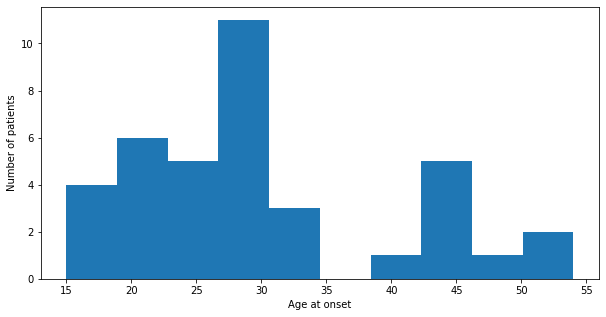

In [184]:
plt.figure(figsize=(10, 5))
patients_df["Age at onset "].plot(kind="hist")
plt.xlabel("Age at onset")
plt.ylabel("Number of patients")

In [185]:
patients_df["Date of Exam "] = pd.to_datetime(patients_df["Date of Exam "])

In [186]:
im = Image.open(
    "data/Initial & repeat MRI in MS-Free Dataset/TZN/1/IM_00010.TIF")
lesion_scan = np.array(im)

In [187]:
lesion_data = loadmat(
    "data/Initial & repeat MRI in MS-Free Dataset/TZN/1/IM_00010_1.plq")

## Lesion description
- T2 weighted Brain white matter lesions
- Occur in patients with Clinically Isolated syndrom -> Subclass of Multiple Sclerosis

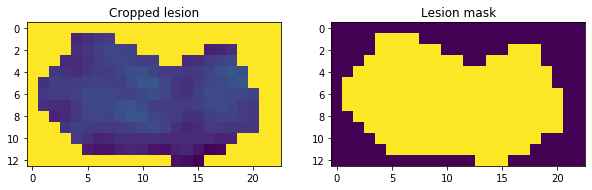

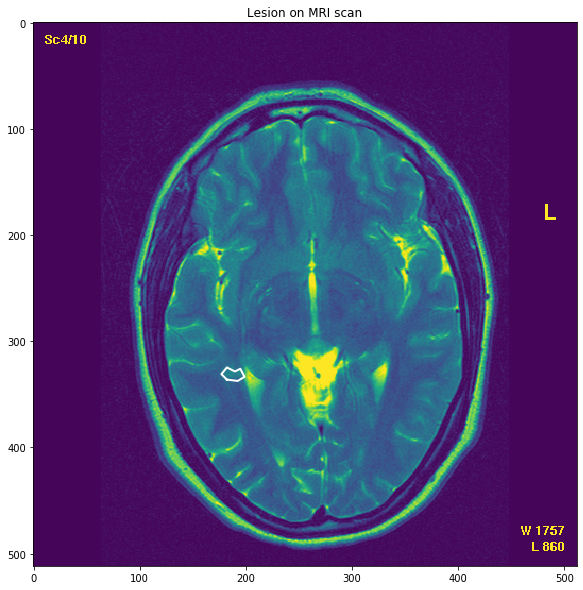

In [188]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(lesion_data["reg"])
plt.title("Cropped lesion")
plt.subplot(122)
plt.imshow(lesion_data["mask"])
plt.title("Lesion mask")
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(lesion_scan)
plt.plot(lesion_data["xi"], lesion_data["yi"], color="white", linewidth=2)
plt.title("Lesion on MRI scan")
plt.show()

In [189]:
def process_plq(path):
    params = loadmat(path)
    return params["mask"].sum(), (params["reg"] * params["mask"]).mean() / 255

In [190]:
!ls "data/Initial & repeat MRI in MS-Free Dataset/AA/1"

IM_00023.TIF
IM_00024.TIF
IM_00025.TIF
IM_00026.TIF
IM_00027.TIF
IM_00028.TIF
IM_00028.plq
IM_00029.TIF
IM_00030.TIF
IM_00030.plq
IM_00031.TIF
IM_00031.plq
IM_00031_1.plq
IM_00032.TIF
IM_00032.plq
IM_00032_1.plq
IM_00032_2.plq
IM_00032_3.plq
IM_00033.TIF
IM_00033.plq
IM_00033_1.plq
IM_00033_2.plq
IM_00034.TIF
IM_00034.plq
IM_00035.TIF
IM_00035.plq
IM_00035_1.plq
IM_00035_2.plq
IM_00036.TIF
IM_00036.plq
IM_00036_1.plq
IM_00037.TIF
IM_00037.plq
IM_00037_1.plq
IM_00037_2.plq
IM_00037_3.plq
IM_00037_4.plq
IM_00037_5.plq
IM_00038.TIF
IM_00038.plq
IM_00038_1.plq
IM_00038_2.plq
IM_00038_3.plq
IM_00039.TIF
IM_00039.plq
IM_00039_1.plq
IM_00039_2.plq
IM_00039_3.plq
IM_00040.TIF
IM_00040.plq
IM_00040_1.plq
IM_00040_2.plq
IM_00041.TIF
IM_00041.plq
IM_00041_1.plq
IM_00042.TIF
IM_00042.plq
IM_00043.TIF
IM_00043.plq
IM_00044.TIF


In [191]:
shapes = []
for root, dirs, files in os.walk("data/Initial & repeat MRI in MS-Free Dataset/"):
    path = root.split(os.sep)
    for file in files:
        if ".plq" in file:
#             print(root.split("/"))
#             _, _, patient, stage = root.split("/")
            temp = root.split("/")[-1].split("\\")
            patient, stage = temp
            path = root + "/" + file
            size, intensity = process_plq(path)
            shapes.append((size, intensity, patient, stage))

In [192]:
shapes_df = pd.DataFrame(shapes, columns=["size", "intensity", "patient", "stage"])

In [193]:
patient_progress_df = shapes_df.groupby(["stage", "patient"])[["intensity", "size"]].agg({
    "intensity": "mean",
    "size": ["count", "mean"]
}).reset_index()

In [194]:
patient_progress_df.columns = ["stage", "patient", "number", "size", "intensity"]

In [195]:
patient_progress_df = patient_progress_df[patient_progress_df["stage"] == "1"][["patient", "number", "intensity", "size"]].merge(
    patient_progress_df[patient_progress_df["stage"] == "2"][["patient", "number", "intensity", "size"]],
    how="left",
    on="patient",
    suffixes=("_initial", "_repeated")
)

In [196]:
patient_progress_df["size_change"] = patient_progress_df["size_repeated"] / patient_progress_df["size_initial"]
patient_progress_df["intensity_change"] = patient_progress_df["intensity_repeated"] / patient_progress_df["intensity_initial"]
patient_progress_df["number_change"] = patient_progress_df["number_repeated"] / patient_progress_df["number_initial"]

In [197]:
patient_progress_df.sort_values("intensity_change", ascending=False).head()

,patient,number_initial,intensity_initial,size_initial,number_repeated,intensity_repeated,size_repeated,size_change,intensity_change,number_change
37,TZN,0.215658,132.250000,4,0.266447,333.285714,28,7.000000,2.520119,1.235508
35,TSA,0.175778,54.333333,24,0.173991,93.763158,38,1.583333,1.725702,0.989835
10,GPE,0.236244,130.928571,42,0.210275,199.779661,59,1.404762,1.525868,0.890078
22,MK,0.389462,220.875000,8,0.335483,334.384615,13,1.625000,1.513909,0.861402
28,PRI,0.205052,139.754098,61,0.192825,188.983333,60,0.983607,1.352256,0.940372


In [198]:
patient_progress_df.drop(37, inplace=True)

In [199]:
patient_progress_df = patient_progress_df.merge(patients_df, left_on="patient", right_on="CODE")

In [200]:
patient_progress_df['Unnamed: 4'].unique()

array([nan])

In [201]:
patient_progress_df = patient_progress_df.drop(['Unnamed: 4'],axis=1)

## Merged dataframe 1

In [202]:
patient_progress_df.head()

,patient,number_initial,intensity_initial,size_initial,number_repeated,intensity_repeated,size_repeated,size_change,intensity_change,number_change,N,Date Of bitrh,Date of Exam,Age at onset,CODE
0,AA,0.308227,185.026316,38,0.308126,186.000000,36,0.947368,1.005262,0.999671,2.0,1973-10-20,2003-11-12,30.0,AA
1,ARK,0.218597,38.142857,7,0.190021,33.000000,10,1.428571,0.865169,0.869278,23.0,1962-10-02,2005-06-23,43.0,ARK
2,AT,0.289054,95.111111,9,0.197010,80.625000,8,0.888889,0.847693,0.681566,1.0,1970-01-05,2004-05-24,34.0,AT
3,CHP,0.157853,30.368421,19,0.212683,29.181818,22,1.157895,0.960926,1.347349,24.0,1977-12-11,2007-10-01,30.0,CHP
4,CK,0.124341,132.807692,26,0.235026,106.256410,39,1.500000,0.800077,1.890171,37.0,1978-05-30,2008-02-11,30.0,CK


In [203]:
patient_progress_df = patient_progress_df.drop(['CODE'],axis=1)

Text(0, 0.5, 'Mean intensity change')

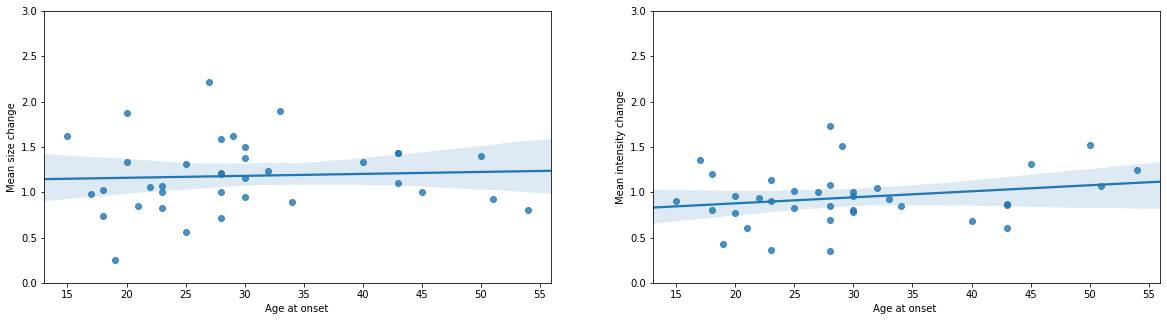

In [204]:
plt.figure(figsize=(20, 5))
# plt.title("Dependency between age and a course of a disease")
plt.subplot(121)
sns.regplot(patient_progress_df["Age at onset "], patient_progress_df["size_change"])
plt.ylim(0, 3)
plt.ylabel("Mean size change")

plt.subplot(122)
sns.regplot(patient_progress_df["Age at onset "], patient_progress_df["intensity_change"])
plt.ylim(0, 3)
plt.ylabel("Mean intensity change")

## EDSS

In [205]:
edss_df = pd.read_csv('data/edss.csv')

In [206]:
edss_df.head(30)

,Unnamed: 0,CODE,EDSS2,EDSS5
0,0,AT,1.0,(2.0)
1,1,AA,2.0,(2.0)
2,2,GPE,3.0,(3.0)
3,3,HC,1.5,(2.5)
4,4,IO,3.0,(2.5)
5,5,MJ,1.5,(1.5)
6,6,IPH,2.5,(3.0)
7,7,KM,1.0,(1.0)
8,8,NP,2.5,(5.0)
9,9,TA,2.0,(2.5)


In [207]:
edss_df = edss_df.drop(['Unnamed: 0'],axis = 1)

In [208]:
patient_progress_df.shape

(36, 14)

In [209]:
edss_df.shape

(38, 3)

## Merge with EDSS

In [301]:
final_edss_pat = pd.merge(patient_progress_df,edss_df, left_on='patient',right_on='CODE')

In [302]:
final_edss_pat.head()

,patient,number_initial,intensity_initial,size_initial,number_repeated,intensity_repeated,size_repeated,size_change,intensity_change,number_change,N,Date Of bitrh,Date of Exam,Age at onset,CODE,EDSS2,EDSS5
0,AA,0.308227,185.026316,38,0.308126,186.000000,36,0.947368,1.005262,0.999671,2.0,1973-10-20,2003-11-12,30.0,AA,2.0,(2.0)
1,ARK,0.218597,38.142857,7,0.190021,33.000000,10,1.428571,0.865169,0.869278,23.0,1962-10-02,2005-06-23,43.0,ARK,2.0,(2.5)
2,AT,0.289054,95.111111,9,0.197010,80.625000,8,0.888889,0.847693,0.681566,1.0,1970-01-05,2004-05-24,34.0,AT,1.0,(2.0)
3,CHP,0.157853,30.368421,19,0.212683,29.181818,22,1.157895,0.960926,1.347349,24.0,1977-12-11,2007-10-01,30.0,CHP,2.0,(2.5)
4,CK,0.124341,132.807692,26,0.235026,106.256410,39,1.500000,0.800077,1.890171,37.0,1978-05-30,2008-02-11,30.0,CK,2.0,(2.0)


In [303]:
def fix_edss5(x):
    x = x.replace(')','')
    x = x.replace('(','')
    return x

In [304]:
final_edss_pat['EDSS5'] = final_edss_pat['EDSS5'].apply(fix_edss5).astype('float32')

In [305]:
final_edss_pat['EDSS2'].unique()

array([2. , 1. , 3. , 1.5, 2.5, 3.5])

In [306]:
final_edss_pat['EDSS5'].unique()

array([2. , 2.5, 1. , 3. , 5. , 1.5, 4.5, 4. ])

## EDSS Score
- Expanded Disability Status Scale (EDSS)
- 1-10 Scale: Quantify disability in Multiple Sclerosis
- Monitor changes over time
- 0.5 unit increments
- EDSS steps 1.0 to 4.5 refer to people with MS who are able to walk without any aid
- EDSS steps 5.0 to 9.5 are defined by the impairment to walking
- EDSS(2) -> 20% Stabilized
- EDSS(5) -> 50% Stabilized


## Hypothesis testing part

In [216]:
for a in final_edss_pat.columns:
    print(f'{a} -> {final_edss_pat[a].isna().sum()}')

patient -> 0
number_initial -> 0
intensity_initial -> 0
size_initial -> 0
number_repeated -> 0
intensity_repeated -> 0
size_repeated -> 0
size_change -> 0
intensity_change -> 0
number_change -> 0
N -> 0
Date Of bitrh  -> 0
Date of Exam  -> 0
Age at onset  -> 0
CODE -> 0
EDSS2 -> 0
EDSS5 -> 0


### Trying correlation map

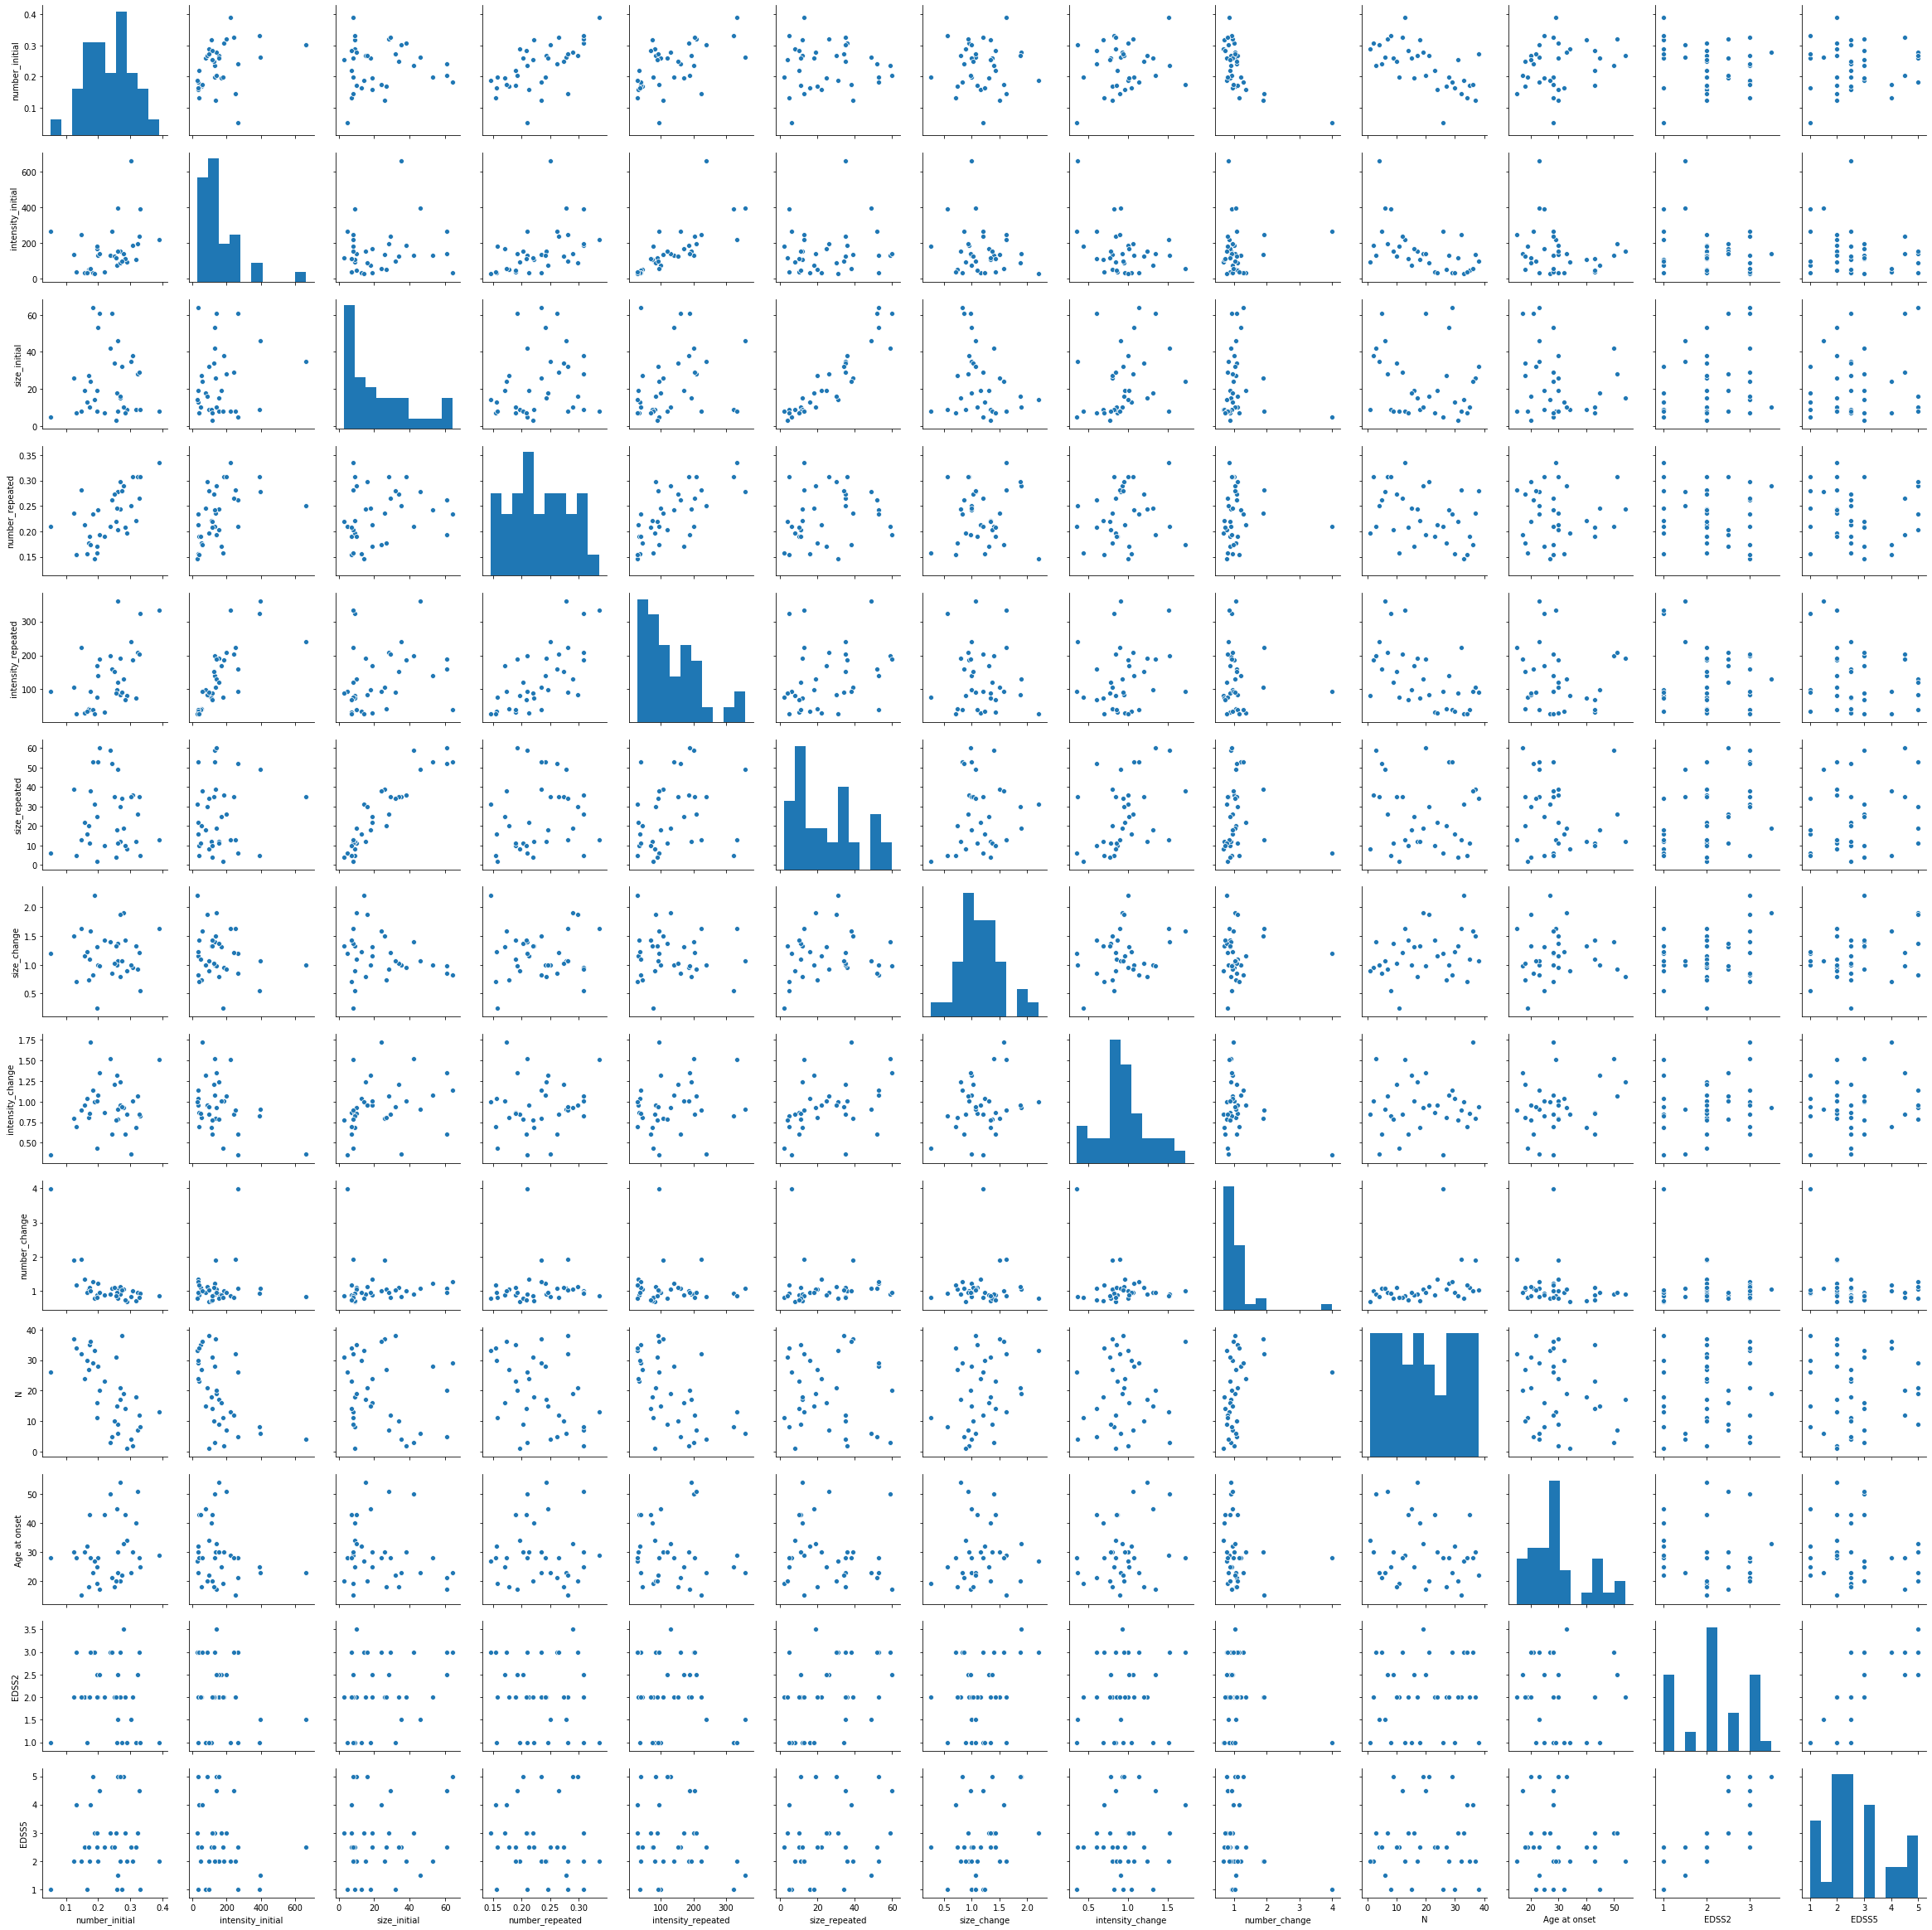

In [217]:
sns.pairplot(final_edss_pat)

In [218]:
final_edss_pat.corr(method='pearson')

,number_initial,intensity_initial,size_initial,number_repeated,intensity_repeated,size_repeated,size_change,intensity_change,number_change,N,Age at onset,EDSS2,EDSS5
number_initial,1.000000,0.340326,0.010437,0.620532,0.532368,-0.011283,-0.013043,0.149943,-0.629970,-0.637955,0.216633,-0.150246,0.053873
intensity_initial,0.340326,1.000000,0.164919,0.452640,0.748670,0.107427,-0.206563,-0.362844,0.105939,-0.524532,-0.216820,-0.235951,-0.212191
size_initial,0.010437,0.164919,1.000000,0.193167,0.242562,0.926771,-0.261352,0.267192,-0.068603,-0.174232,-0.233280,0.282968,0.150372
number_repeated,0.620532,0.452640,0.193167,1.000000,0.668655,0.171423,0.042244,0.130776,0.031419,-0.368273,-0.031711,-0.136798,-0.105019
intensity_repeated,0.532368,0.748670,0.242562,0.668655,1.000000,0.243574,-0.092778,0.194036,-0.064858,-0.555595,-0.080511,-0.167119,-0.182473
size_repeated,-0.011283,0.107427,0.926771,0.171423,0.243574,1.000000,0.056071,0.402994,-0.067491,-0.096011,-0.183160,0.391442,0.227215
size_change,-0.013043,-0.206563,-0.261352,0.042244,-0.092778,0.056071,1.000000,0.243717,0.055809,0.294495,0.055677,0.285811,0.289193
intensity_change,0.149943,-0.362844,0.267192,0.130776,0.194036,0.402994,0.243717,1.000000,-0.273305,0.067698,0.221927,0.182407,0.130401
number_change,-0.629970,0.105939,-0.068603,0.031419,-0.064858,-0.067491,0.055809,-0.273305,1.000000,0.313345,-0.161315,-0.158969,-0.252264
N,-0.637955,-0.524532,-0.174232,-0.368273,-0.555595,-0.096011,0.294495,0.067698,0.313345,1.000000,-0.181688,0.084965,0.015325


### Related features

- size_initial ; size_repeated
- number_initial ; number_repeated
- intensity_initial ; intensity_repeated
- intensity_repeated ; number_repeated
- EDSS2 ; EDSS5
- EDSS2 ; size_repeated
- EDSS5 ; size_change

### Adding more features

In [219]:
final_edss_pat.columns

Index(['patient', 'number_initial', 'intensity_initial', 'size_initial',
       'number_repeated', 'intensity_repeated', 'size_repeated', 'size_change',
       'intensity_change', 'number_change', 'N', 'Date Of bitrh ',
       'Date of Exam ', 'Age at onset ', 'CODE', 'EDSS2', 'EDSS5'],
      dtype='object')

In [220]:
final_edss_pat.head(1)

,patient,number_initial,intensity_initial,size_initial,number_repeated,intensity_repeated,size_repeated,size_change,intensity_change,number_change,N,Date Of bitrh,Date of Exam,Age at onset,CODE,EDSS2,EDSS5
0,AA,0.308227,185.026316,38,0.308126,186.0,36,0.947368,1.005262,0.999671,2.0,1973-10-20,2003-11-12,30.0,AA,2.0,2.0


In [307]:
final_edss_pat['patient'] = final_edss_pat.patient.astype('category').cat.codes

In [308]:
final_edss_pat['CODE'] = final_edss_pat.patient.astype('category').cat.codes

In [309]:
# final_edss_pat['Date Of bitrh '] =
basedate = pd.Timestamp('2020-01-27')
# final_edss_pat['Date Of bitrh '] = final_edss_pat['Date Of bitrh '].to_datetime()
final_edss_pat['Age'] = final_edss_pat['Date Of bitrh '].apply(lambda x: int((basedate - x).days/365))

In [310]:
final_edss_pat['TimeFromExam'] = final_edss_pat['Date of Exam '].apply(lambda x: int((basedate - x).days/365)).astype(int)

In [311]:
final_edss_pat_back = final_edss_pat.copy()

In [312]:
final_edss_pat = final_edss_pat.drop(['Date of Exam '],axis = 1)

In [313]:
final_edss_pat = final_edss_pat.drop(['Date Of bitrh '],axis = 1)

In [314]:
final_edss_pat.head(2)

,patient,number_initial,intensity_initial,size_initial,number_repeated,intensity_repeated,size_repeated,size_change,intensity_change,number_change,N,Age at onset,CODE,EDSS2,EDSS5,Age,TimeFromExam
0,0,0.308227,185.026316,38,0.308126,186.0,36,0.947368,1.005262,0.999671,2.0,30.0,0,2.0,2.0,46,16
1,1,0.218597,38.142857,7,0.190021,33.0,10,1.428571,0.865169,0.869278,23.0,43.0,1,2.0,2.5,57,14


In [228]:
final_edss_pat.dtypes

patient                  int8
number_initial        float64
intensity_initial     float64
size_initial            int64
number_repeated       float64
intensity_repeated    float64
size_repeated           int64
size_change           float64
intensity_change      float64
number_change         float64
N                     float64
Age at onset          float64
CODE                     int8
EDSS2                 float64
EDSS5                 float32
Age                     int64
TimeFromExam            int32
dtype: object

### Feature Importance

In [315]:
from sklearn.tree import DecisionTreeRegressor

In [316]:
X, y = final_edss_pat.drop(['EDSS2'],axis = 1),final_edss_pat['EDSS2']

In [317]:
clf = DecisionTreeRegressor()
model = clf.fit(X, np.ravel(y))

In [318]:
fi = model.feature_importances_;fi

array([0.009578, 0.099172, 0.      , 0.075022, 0.      , 0.      , 0.0187  , 0.      , 0.      , 0.04867 , 0.051179,
       0.010216, 0.      , 0.687465, 0.      , 0.      ])

In [319]:
d = {final_edss_pat.columns[x]:fi[x] for x in range(len(fi))};d

{'patient': 0.009577864490954251,
 'number_initial': 0.0991715877553574,
 'intensity_initial': 0.0,
 'size_initial': 0.0750215375259727,
 'number_repeated': 0.0,
 'intensity_repeated': 0.0,
 'size_repeated': 0.018699640196624755,
 'size_change': 0.0,
 'intensity_change': 0.0,
 'number_change': 0.04866974104292234,
 'N': 0.05117869005772576,
 'Age at onset ': 0.010216388790350982,
 'CODE': 0.0,
 'EDSS2': 0.6874645501400918,
 'EDSS5': 0.0,
 'Age': 0.0}

### Trying other plots

In [321]:
final_edss_pat_back.head()

,patient,number_initial,intensity_initial,size_initial,number_repeated,intensity_repeated,size_repeated,size_change,intensity_change,number_change,N,Date Of bitrh,Date of Exam,Age at onset,CODE,EDSS2,EDSS5,Age,TimeFromExam
0,0,0.308227,185.026316,38,0.308126,186.000000,36,0.947368,1.005262,0.999671,2.0,1973-10-20,2003-11-12,30.0,0,2.0,2.0,46,16
1,1,0.218597,38.142857,7,0.190021,33.000000,10,1.428571,0.865169,0.869278,23.0,1962-10-02,2005-06-23,43.0,1,2.0,2.5,57,14
2,2,0.289054,95.111111,9,0.197010,80.625000,8,0.888889,0.847693,0.681566,1.0,1970-01-05,2004-05-24,34.0,2,1.0,2.0,50,15
3,3,0.157853,30.368421,19,0.212683,29.181818,22,1.157895,0.960926,1.347349,24.0,1977-12-11,2007-10-01,30.0,3,2.0,2.5,42,12
4,4,0.124341,132.807692,26,0.235026,106.256410,39,1.500000,0.800077,1.890171,37.0,1978-05-30,2008-02-11,30.0,4,2.0,2.0,41,11


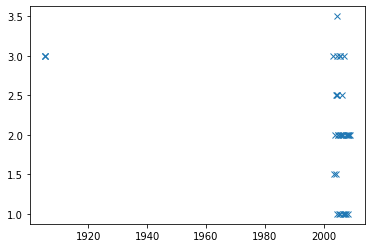

In [335]:
plt.plot_date(final_edss_pat_back['Date of Exam '],final_edss_pat_back['EDSS2'],xdate=True,fmt='x')

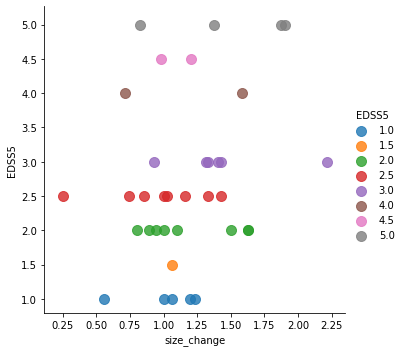

In [356]:
sns.lmplot('size_change', 'EDSS5', 
           data=final_edss_pat_back, 
           fit_reg=False, 
           hue="EDSS5",  
           scatter_kws={"marker": "D", 
                        "s": 100})

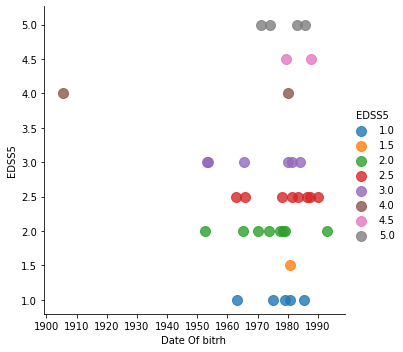

In [351]:
sns.lmplot('Date Of bitrh ', 'EDSS5', 
           data=final_edss_pat_back, 
           fit_reg=False, 
           hue="EDSS5",  
           scatter_kws={"marker": "D", 
                        "s": 100})

## Hypothesis
- I propose that looking at the correlation of the values from 1.8.2 and 1.8.4, we can identify related factors that influence the EDSS score
- Also looking into the most common occurencess in the EDSS scale (eg 2.0, 2.5) might yield futher information